In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import os 
import shutil
from ultralytics import YOLO 

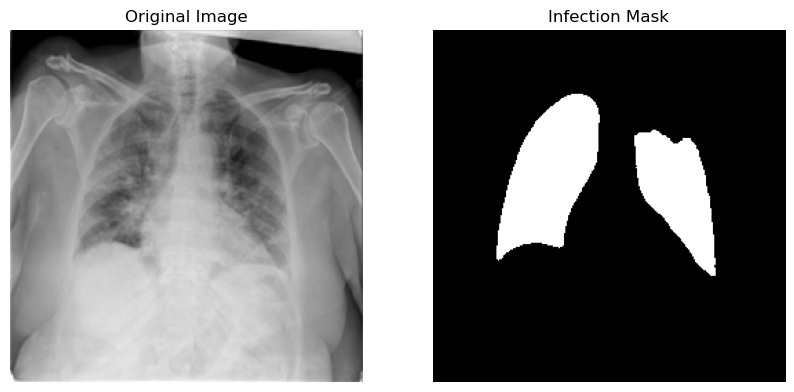

In [ ]:
img = cv2.imread("/Users/hungcucu/Documents/usth/MLmedicine/COVID-QU-EX/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_1.png")
mask = cv2.imread("/Users/hungcucu/Documents/usth/MLmedicine/COVID-QU-EX/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks/covid_1.png",cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Infection Mask")
plt.axis("off")
plt.show()

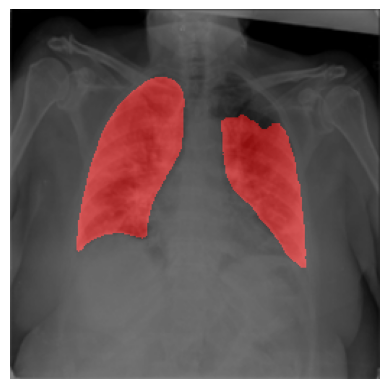

In [4]:
img = cv2.imread("/Users/hungcucu/Documents/usth/MLmedicine/COVID-QU-EX/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_1.png")
mask = cv2.imread("/Users/hungcucu/Documents/usth/MLmedicine/COVID-QU-EX/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks/covid_1.png",cv2.IMREAD_GRAYSCALE)

colored_mask = np.zeros_like(img)
colored_mask[:,:,0] = mask  
overlay = cv2.addWeighted(img, 0.5, colored_mask, 0.5, 0)
plt.imshow(overlay)
plt.axis("off")
plt.show()

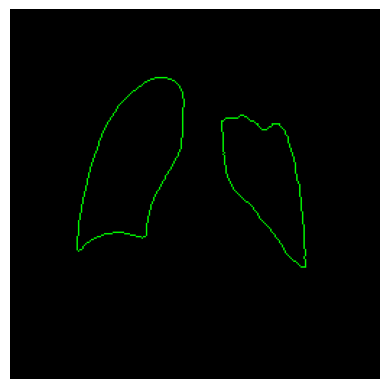

In [3]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
back = np.zeros_like(img)
cv2.drawContours(back, contours, -1, (0, 255, 0), 1)
plt.imshow(cv2.cvtColor(back, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# CONVERT TO YOLO FORMAT

In [8]:
def convert_to_yolo_polygon(mask_image,output_path:str,class_id:int=0):
    mask = cv2.imread(mask_image,cv2.IMREAD_GRAYSCALE)
    img_h, img_w = mask.shape
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    with open(output_path, "w") as f:
        for cnt in contours:
            poly = cnt[:,0,:]
            poly_norm = poly.astype(np.float32)
            poly_norm[:,0] /= img_w
            poly_norm[:,1] /= img_h
            flat = poly_norm.reshape(-1)
            line = str(class_id) + " " + " ".join([f"{v}" for v in flat]) + "\n"
            f.write(line)

In [9]:
def convert_to_yolo_folder_format(source_dir,output_dir):
    os.makedirs(output_dir,exist_ok=True)
    for tag in ["images","labels"]:
        for folder in ["train","val","test"]:
            os.makedirs(os.path.join(output_dir,tag,folder),exist_ok=True)
    #split
    train_files = [f for f in sorted(os.listdir(os.path.join(source_dir,"Train/COVID-19/images")))]
    val_files = [f for f in sorted(os.listdir(os.path.join(source_dir,"Val/COVID-19/images")))]
    test_files = [f for f in sorted(os.listdir(os.path.join(source_dir,"Test/COVID-19/images")))]
    #yolo format
    for train_file in train_files:
        img_path = os.path.join(source_dir,"Train/COVID-19/images",train_file)
        mask_path = os.path.join(source_dir,"Train/COVID-19/infection masks",train_file)
        convert_to_yolo_polygon(mask_path,os.path.join(output_dir,"labels","train",train_file.replace(".png",".txt")))
        shutil.copy(img_path,os.path.join(output_dir,"images","train",train_file))
    for val_file in val_files:    
        img_path = os.path.join(source_dir,"Val/COVID-19/images",val_file)
        mask_path = os.path.join(source_dir,"Val/COVID-19/infection masks",val_file )
        convert_to_yolo_polygon(mask_path,os.path.join(output_dir,"labels","val",val_file.replace(".png",".txt")))
        shutil.copy(img_path,os.path.join(output_dir,"images","val",val_file))
    for test_file in test_files:
        img_path = os.path.join(source_dir,"Test/COVID-19/images",test_file)
        mask_path = os.path.join(source_dir,"Test/COVID-19/infection masks",test_file)
        convert_to_yolo_polygon(mask_path,os.path.join(output_dir,"labels","test",test_file.replace(".png",".txt")))
        shutil.copy(img_path,os.path.join(output_dir,"images","test",test_file))
    #yaml file
    yaml = f"""path:{output_dir}
train: images/train
val: images/val

nc: 1
names: 
    0: infection_area
    """
    with open(os.path.join(output_dir,"data.yaml"),"w") as f:
        f.write(yaml)

In [10]:
source_dir = "/Users/hungcucu/Documents/usth/MLmedicine/COVID-QU-EX/covidqu/Infection Segmentation Data/Infection Segmentation Data"
output_dir = "/Users/hungcucu/Documents/usth/MLmedicine/InfectionAreaCOVID19/yolodataset"
convert_to_yolo_folder_format(source_dir,output_dir)

In [4]:
sum = 0 
for tag in ["Train","Val","Test"]:
    sum += len(os.listdir(f"/Users/hungcucu/Documents/usth/MLmedicine/COVID-QU-EX/covidqu/Infection Segmentation Data/Infection Segmentation Data/{tag}/COVID-19/images"))
print(sum)

2913


In [ ]:
!yolo task=segment model=yolo11s-seg.pt mode=train data=/kaggle/working/yolodataset/data.yaml epochs=100 batch=16 name=infection_area-yolov11s patience=30


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      1/100      5.72G      1.498      2.855      2.185      1.577          0         37        640: 100% ━━━━━━━━━━━━ 117/117 2.0it/s 59.7s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.1it/s 7.2s0.5s
                   all        466        933     0.0404      0.102     0.0245    0.00883     0.0493     0.0879     0.0251    0.00793

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      2/100      5.77G      1.486      2.565      1.603      1.512          0         39        640: 100% ━━━━━━━━━━━━ 117/117 2.2it/s 52.0s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.1it/s 7.1s0.5s
                   all        466        933      0.291      0.373      0.262     0.0994      0.265      0.312      0.206     0.0724

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      3/100      5.87G      1.439      2.493      1.511      1.478          0         23        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.7s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.1it/s 7.1s0.5s
                   all        466        933      0.337      0.312      0.222      0.079      0.313      0.229      0.145     0.0361

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      4/100      5.87G      1.434      2.497       1.53      1.469          0         32        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.1it/s 7.1s0.5s
                   all        466        933      0.477      0.509      0.393      0.193      0.433       0.48      0.338      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      5/100      5.83G      1.371      2.434      1.448      1.432          0         34        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.4s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.3it/s 6.6s0.5s
                   all        466        933      0.462      0.372      0.374      0.181      0.467      0.337      0.332      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     96/100      5.79G     0.8439      1.594     0.7022      1.171          0         17        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.5s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.3it/s 6.6s0.5s
                   all        466        933      0.819      0.731       0.82      0.554      0.813      0.725      0.804       0.52

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     97/100      5.84G     0.8406      1.607     0.7049      1.172          0         21        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.4s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.3it/s 6.5s0.5s
                   all        466        933      0.831      0.716      0.813      0.555      0.829      0.715      0.804      0.522

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     98/100      5.88G     0.8288      1.594     0.6847      1.167          0         17        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.5s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.3it/s 6.6s0.5s
                   all        466        933      0.831      0.718      0.814      0.556      0.824      0.733      0.813      0.525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     99/100      5.88G     0.8284      1.567     0.6822      1.156          0         15        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.4s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.3it/s 6.5s0.5s
                   all        466        933      0.833      0.713      0.813      0.557      0.841      0.721      0.811      0.525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
    100/100      5.87G     0.8171       1.56     0.6761      1.149          0         14        640: 100% ━━━━━━━━━━━━ 117/117 2.3it/s 51.5s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.3it/s 6.5s0.5s
                   all        466        933      0.807      0.739      0.817      0.558      0.815      0.743      0.813      0.524

In [ ]:
model = YOLO("/Users/hungcucu/Documents/usth/MLmedicine/InfectionAreaCOVID19/kaggle/working/runs/segment/infection_area-yolov11s/weights/best.pt")
results = model.val(
    data = "/Users/hungcucu/Documents/usth/MLmedicine/InfectionAreaCOVID19/yolodataset/data.yaml",
    split = "test"
)

Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.6.0 CPU (Apple M4)
YOLO11s-seg summary (fused): 114 layers, 10,067,203 parameters, 0 gradients, 32.8 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 162.1±14.9 MB/s, size: 24.4 KB)
val: Scanning /Users/hungcucu/Documents/usth/MLmedicine/InfectionAreaCOVID19/yolodataset/labels/test... 583 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 583/583 4.5Kit/s 0.1s0.1s
val: New cache created: /Users/hungcucu/Documents/usth/MLmedicine/InfectionAreaCOVID19/yolodataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 37/37 0.2it/s 3:306.0ss
                   all        583       1161      0.796      0.714      0.798      0.542       0.81      0.704      0.794      0.509
Speed: 0.5ms preprocess, 353.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /Users/hungcucu/Documents/usth/MLmedicine/mlmed2026/

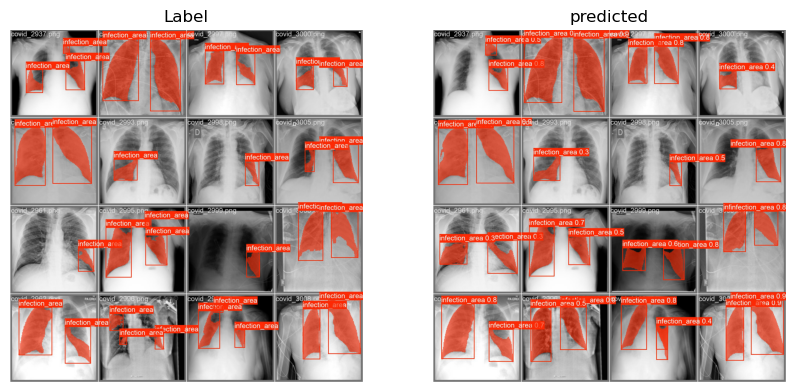

In [6]:
label = "/Users/hungcucu/Documents/usth/MLmedicine/mlmed2026/runs/segment/val2/val_batch2_labels.jpg"
pred = "/Users/hungcucu/Documents/usth/MLmedicine/mlmed2026/runs/segment/val2/val_batch2_pred.jpg"


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(label))
plt.title("Label")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(pred))
plt.title("predicted")
plt.axis("off")
plt.show()